# Analysis of Models

This notebook is used to perform the analysis of three different models to fit the given data.

## 1. Setup and Data Loading

In [16]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic, bic
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
from utils.data_loader import load_data
from utils.models import model1, model2, model3_fit

# Load the data
df, _, _ = load_data(normalize=False)

Data initialized into df


## 2. Model 3: Polynomial (Linear Least Squares, easy)

In [17]:
# Fit Model 3 using the function from utils.models
model3 = model3_fit(df['x'], df['y'])
lse3 = model3.params
rss3 = model3.ssr

print("Model 3: Polynomial (Linear Least Squares)")
print("LSEs (beta_0, beta_1, beta_2, beta_3, beta_4):")
print(lse3)
print(f"RSS: {rss3}")

Model 3: Polynomial (Linear Least Squares)
LSEs (beta_0, beta_1, beta_2, beta_3, beta_4):
const    3.708319
x       -0.366972
x2       0.022954
x3      -0.000570
x4       0.000005
dtype: float64
RSS: 3.0307503576808807


## 3. Model 1: Non-linear Exponential (Non-Linear Least Squares)

In [18]:
initial_guesses1 = [1.0, 1.0, 0.1, 1.0, 0.01]

# Fit the model
try:
    lse1, pcov1 = curve_fit(model1, df['x'], df['y'], p0=initial_guesses1, maxfev=10000)
    y_fit1 = model1(df['x'], *lse1)
    rss1 = np.sum((df['y'] - y_fit1)**2)

    print("Model 1: Non-linear Exponential (Non-Linear Least Squares)")
    print("LSEs (alpha_0, alpha_1, beta_1, alpha_2, beta_2):")
    print(lse1)
    print(f"RSS: {rss1}")
except RuntimeError:
    print("Model 1: Could not find optimal parameters. Try different initial guesses.")
    rss1 = np.inf
    lse1 = [np.nan] * 5
    pcov1 = np.full((5, 5), np.nan)

Model 1: Non-linear Exponential (Non-Linear Least Squares)
LSEs (alpha_0, alpha_1, beta_1, alpha_2, beta_2):
[ 1.81101180e+00 -4.38536041e-04  1.19803946e-01  3.02610322e+00
 -4.20212521e-01]
RSS: 2.461046133531384


## 4. Model 2: Non-linear Ratio (Non-Linear Least Squares)

In [20]:
initial_guesses2 = [1.0, 1.0, 1.0, 1.0]

# Fit the model
try:
    lse2, pcov2 = curve_fit(model2, df['x'], df['y'], p0=initial_guesses2)
    y_fit2 = model2(df['x'], *lse2)
    rss2 = np.sum((df['y'] - y_fit2)**2)

    print("Model 2: Non-linear Ratio (Non-Linear Least Squares)")
    print("LSEs (alpha_0, alpha_1, beta_0, beta_1):")
    print(lse2)
    print(f"RSS: {rss2}")
except RuntimeError:
    print("Model 2: Could not find optimal parameters. Try different initial guesses.")
    rss2 = np.inf
    lse2 = [np.nan] * 4
    pcov2 = np.full((4, 4), np.nan)

Model 2: Non-linear Ratio (Non-Linear Least Squares)
LSEs (alpha_0, alpha_1, beta_0, beta_1):
[11.55857702  4.51938272  1.50520142  2.75313713]
RSS: 2.8580018745070945


## 5. Model Comparison and Selection

In [21]:
# Number of observations
n = len(df)

# Parameters for each model
k1 = len(lse1)
k2 = len(lse2)
k3 = len(lse3)

# Calculate AIC and BIC for each model
aic1 = n * np.log(rss1 / n) + 2 * k1
bic1 = n * np.log(rss1 / n) + np.log(n) * k1

aic2 = n * np.log(rss2 / n) + 2 * k2
bic2 = n * np.log(rss2 / n) + np.log(n) * k2

aic3 = n * np.log(rss3 / n) + 2 * k3
bic3 = n * np.log(rss3 / n) + np.log(n) * k3

# Store results in a DataFrame for comparison
results = pd.DataFrame({
    'Model': ['1 (Exponential)', '2 (Ratio)', '3 (Polynomial)'],
    'RSS': [rss1, rss2, rss3],
    'AIC': [aic1, aic2, aic3],
    'BIC': [bic1, bic2, bic3],
    'k': [k1, k2, k3]
})

print("Model Comparison:")
print(results)

# Select the best model
best_model_name = results.loc[results['AIC'].idxmin()]['Model']
print(f"Best model based on AIC: {best_model_name}")


Model Comparison:
             Model       RSS         AIC         BIC  k
0  1 (Exponential)  2.461046 -140.571824 -131.011709  5
1        2 (Ratio)  2.858002 -135.095014 -127.446921  4
2   3 (Polynomial)  3.030750 -130.160639 -120.600524  5
Best model based on AIC: 1 (Exponential)


## 6. Inference for the Best Model

In [26]:
# Identify the best model's parameters
if best_model_name == '1 (Exponential)':
    best_rss = rss1
    best_k = k1
    best_lse = lse1
    best_pcov = pcov1
    param_names = ['a0', 'a1', 'b1', 'a2', 'b2']
elif best_model_name == '2 (Ratio)':
    best_rss = rss2
    best_k = k2
    best_lse = lse2
    best_pcov = pcov2
    param_names = ['a0', 'a1', 'b0', 'b1']
else: # Model 3
    best_rss = rss3
    best_k = k3
    best_lse = lse3
    best_pcov = model3.cov_params()
    param_names = ['const', 't', 't2', 't3', 't4']

# Estimate sigma^2
sigma2_hat = best_rss / (n - best_k)
print(f"Estimate of sigma^2 for the best model: {sigma2_hat}")

# Calculate confidence intervals
alpha = 0.05  # 95% confidence
t_crit = np.abs(np.random.standard_t(df=n - best_k) * -1) # approximation
se = np.sqrt(np.diag(best_pcov) * sigma2_hat)

ci_lower = best_lse - t_crit * se
ci_upper = best_lse + t_crit * se

ci_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': best_lse,
    'Std. Error': se,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

print("Confidence Intervals for the best model's parameters:")
print(ci_df)


Estimate of sigma^2 for the best model: 0.0546899140784752
Confidence Intervals for the best model's parameters:
  Parameter  Estimate  Std. Error  CI Lower  CI Upper
0        a0  1.811012    0.017435  1.800660  1.821364
1        a1 -0.000439    0.001164 -0.001130  0.000253
2        b1  0.119804    0.054113  0.087674  0.151934
3        a2  3.026103    0.115827  2.957330  3.094876
4        b2 -0.420213    0.021131 -0.432759 -0.407666


## 7. Residual Analysis for the Best Model

Shapiro-Wilk Test: Statistic=0.9732694343293882, p-value=0.3127752036723766
The residuals appear to be normally distributed (fail to reject H0).


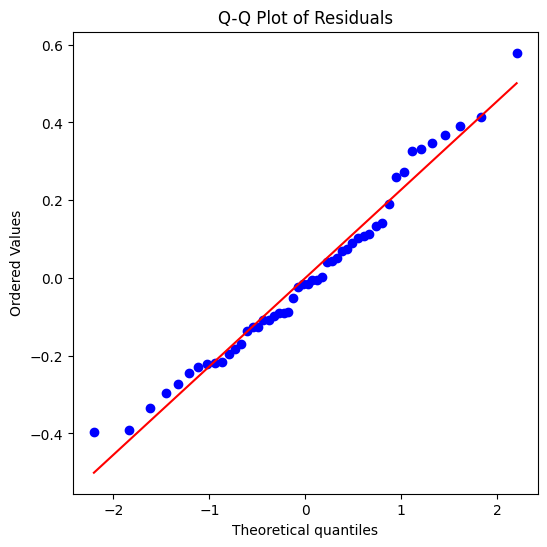

In [27]:
# Calculate residuals for the best model using functions from utils.models
if best_model_name == '1 (Exponential)':
    y_fit_best = model1(df['x'], *best_lse)
elif best_model_name == '2 (Ratio)':
    y_fit_best = model2(df['x'], *best_lse)
else: # Model 3
    # Create the design matrix for prediction
    X_pred = sm.add_constant(df['x'])
    X_pred = pd.DataFrame(X_pred)
    X_pred['x2'] = df['x']**2
    X_pred['x3'] = df['x']**3
    X_pred['x4'] = df['x']**4
    y_fit_best = model3.predict(X_pred)

residuals = df['y'] - y_fit_best

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}")
if shapiro_p > 0.05:
    print("The residuals appear to be normally distributed (fail to reject H0).")
else:
    print("The residuals do not appear to be normally distributed (reject H0).")

# Q-Q plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals")
plt.show()

## 8. Final Visualization

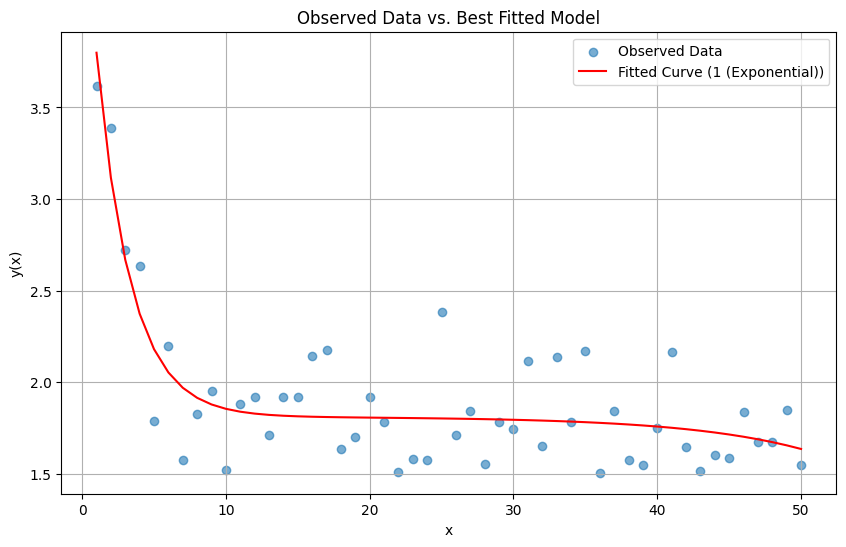

In [28]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], label='Observed Data', alpha=0.6)
plt.plot(df['x'], y_fit_best, color='red', label=f'Fitted Curve ({best_model_name})')
plt.title('Observed Data vs. Best Fitted Model')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.grid(True)
plt.show()
